In [13]:
import sys
sys.path.append("third_parts/microstate_lib/code")
import data_utils
import numpy as np
import os
import re


In [14]:
microstate_base_path = "./data/microstates/epileptic_eeg_dataset"

In [15]:
microstate_folder_files = os.listdir(microstate_base_path)

In [16]:
topo_maps = {
}

segments = {
    
}

In [17]:

for file in microstate_folder_files:
    if file.find("[seg-[prep-asr]]") == 0:
        pass
        # print(file)
    if file.find("[[prep-asr]]") == 0:
        match = re.match(r'\[\[prep-asr\]\]person_(.+)_states4_gev_.*', file)
        person_id = (match.group(1))
        topo_maps[person_id] = np.load(os.path.join(microstate_base_path, file))

del topo_maps["10"]

In [18]:
topo_maps

{'13': array([[ 0.20851397, -0.22213494,  0.37318591,  0.13258671,  0.02355435,
         -0.07526819, -0.49877626,  0.20836671,  0.3213403 ,  0.10982245,
          0.01781777, -0.04629365, -0.48409582, -0.22101551,  0.1392775 ,
          0.0796691 ,  0.02341207, -0.02484316, -0.13314587,  0.07865858,
         -0.01063201],
        [ 0.17365029,  0.17602313,  0.12863909,  0.28501756,  0.31305901,
          0.30493112,  0.08199489, -0.17859657, -0.06418204,  0.14582871,
          0.2048677 ,  0.1677154 , -0.11045745, -0.18481313, -0.25501991,
         -0.02903092, -0.05174867, -0.02647077, -0.28669517, -0.36276016,
         -0.43195212],
        [-0.63072881, -0.64138466, -0.07251695, -0.05155266, -0.01351062,
         -0.03245103, -0.08405044,  0.14249426,  0.10730904,  0.06964855,
          0.07549301,  0.06565986,  0.10669817,  0.13867353,  0.12828011,
          0.10544346,  0.10779447,  0.09764827,  0.1167354 ,  0.13396865,
          0.1303484 ],
        [-0.19851128, -0.17799281, -0

In [164]:
keys = ['11', '12', '13', '14', '15', 'all']

In [167]:
for key in keys:
    topo_maps[key] = data_utils.match_reorder_topomaps(topo_maps[key], topo_maps['14'])

In [98]:

from sklearn.metrics.pairwise import cosine_similarity


In [99]:
for key in keys:
    print(data_utils.match_reorder_topomaps(topo_maps[key], topo_maps['all'], return_correlation=True)[1])

[0.99993609 0.50308154 0.05762549 0.95992907]
[0.06891002 0.88572235 0.9999323  0.27737448]
[0.29619457 0.15595251 0.14561039 0.70427455]
[0.36863169 0.45768446 0.10176334 0.83345479]
[0.35129973 0.21053797 0.06137782 0.78427651]
[1. 1. 1. 1.]


In [19]:
import plotting
import mne
import string
def plot_maps(maps, info, show=True):
    import mne
    import matplotlib.pyplot as plt
    """Plot prototypical microstate maps.

    Parameters
    ----------
    maps : ndarray, shape (n_maps, n_channels)
        The prototypical microstate maps.
    info : instance of mne.io.Info
        The info structure of the dataset, containing the location of the
        sensors.
    """
    assert len(maps) != 1, 'Only one map found, cannot plot'
    fig, axes = plt.subplots(1, len(maps), figsize=(2 * len(maps), 2))
    for i, (ax, map) in enumerate(zip(axes, maps)):
        mne.viz.plot_topomap(map, info, axes=ax, show=False)
        ax.set_title('Microstate %d' % (i+1))
    plt.tight_layout()
    if show:
        plt.show()
        
def plot_eeg_topomaps(
    topomaps,
    mne_info,
    xlabels=None,
    title="",
    plot_minmax_vec=False,
    fname=None,
    **kwargs,
):
    """
    Plots microstate maps.

    :param topomaps: microstate topographies to plot, no states x channels
    :type topomaps: np.ndarray
    :param mne_info: info from mne as per channels and locations
    :type mne_info: `mne.io.meas_info.Info`
    :param xlabels: labels for topomaps maps, usually correlation with
        template
    :type xlabels: list[str]
    :param title: title for the plot
    :type title: str
    :param plot_minmax_vec: whether to plot vector between minimum and maximum
        loading of the topographies
    :type plot_minmax_vec: bool
    :param fname: filename for the plot, if None, will show
    :type fname: str|None
    """

    plt.figure(figsize=((np.ceil(topomaps.shape[0] / 2.0)) * 5, 12))

    ms_names = list(string.ascii_uppercase)[: topomaps.shape[0]]

    if xlabels is None:
        xlabels = ["" for i in range(topomaps.shape[0])]

    for i, t, xlab in zip(range(topomaps.shape[0]), ms_names, xlabels):
        ax = plt.subplot(2, int(np.ceil(topomaps.shape[0] / 2.0)), i + 1)
        mne.viz.plot_topomap(topomaps[i, :], mne_info, show=False, contours=10, ax=ax)

        if plot_minmax_vec:
            max_sen = np.argmax(topomaps[i, :])
            min_sen = np.argmin(topomaps[i, :])
            pos_int = mne.channels.layout._find_topomap_coords(
                mne_info, picks="eeg"
            )
            plt.gca().plot(
                [pos_int[min_sen, 0], pos_int[max_sen, 0]],
                [pos_int[min_sen, 1], pos_int[max_sen, 1]],
                "ko-",
                markersize=7,
                lw=2.2,
            )
        plt.title(t, fontsize=25)
        plt.xlabel(xlab, fontsize=22)

    plt.suptitle(title, fontsize=30)

    if fname is None:
        plt.show()
    else:
        plt.savefig(fname, bbox_inches="tight", dpi=150, **kwargs)
    plt.close()
    

In [20]:
raw = mne.io.read_raw('/home/wanhong-huang/EMBC2025-reproduce/data/dataset/epileptic_eeg_dataset/Raw_EDF_Files/p11_Record1.edf')
raw.drop_channels(['ECG EKG', 'Manual'])
mont1020 = mne.channels.make_standard_montage('standard_1020')
mne.rename_channels(raw.info, {ch_name:ch_name.replace("EEG ", "").replace("-Ref", "") for ch_name in raw.info['ch_names']})
raw.set_montage(mont1020)
raw.info


/tmp/ipykernel_97421/3328032815.py:1: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw('/home/wanhong-huang/EMBC2025-reproduce/data/dataset/epileptic_eeg_dataset/Raw_EDF_Files/p11_Record1.edf')
/tmp/ipykernel_97421/3328032815.py:1: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw('/home/wanhong-huang/EMBC2025-reproduce/data/dataset/epileptic_eeg_dataset/Raw_EDF_Files/p11_Record1.edf')
/tmp/ipykernel_97421/3328032815.py:1: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  raw = mne.io.read_raw('/home/wanhong-huang/EMBC2025-reproduce/data/dataset/epileptic_eeg_dataset/Raw_EDF_Files/p11_Record1.edf')


<Info | 9 non-empty values
 bads: []
 ch_names: Fp2, Fp1, F8, F4, Fz, F3, F7, A2, T4, C4, Cz, C3, T3, A1, T6, ...
 chs: 21 EEG
 custom_ref_applied: False
 dig: 24 items (3 Cardinal, 21 EEG)
 highpass: 1.0 Hz
 lowpass: 70.0 Hz
 meas_date: 2014-12-22 13:58:50 UTC
 nchan: 21
 projs: []
 sfreq: 500.0 Hz
 subject_info: 3 items (dict)
>

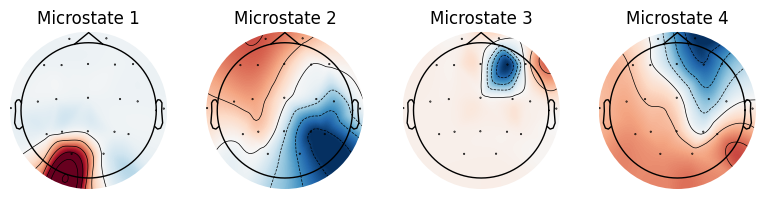

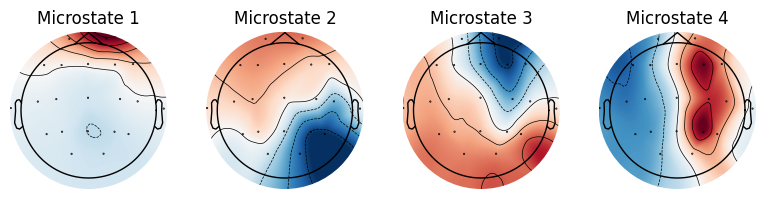

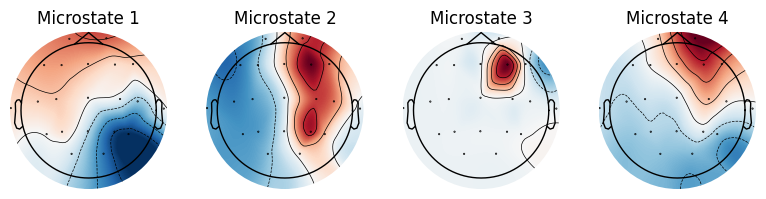

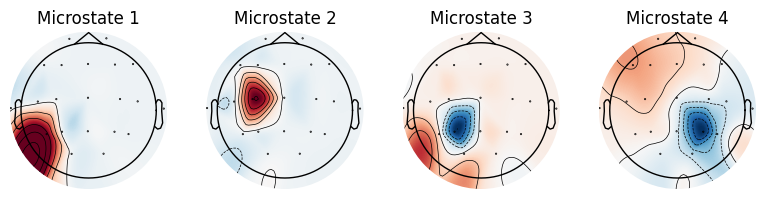

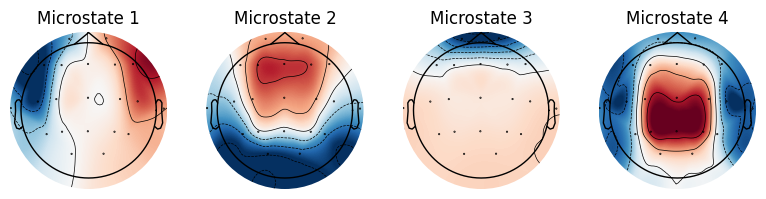

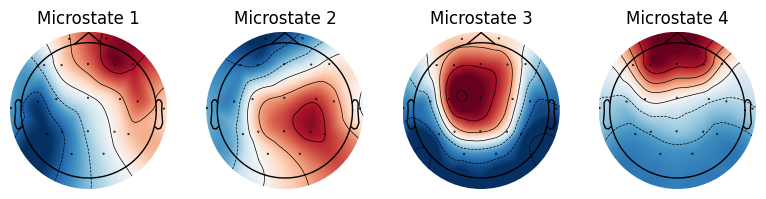

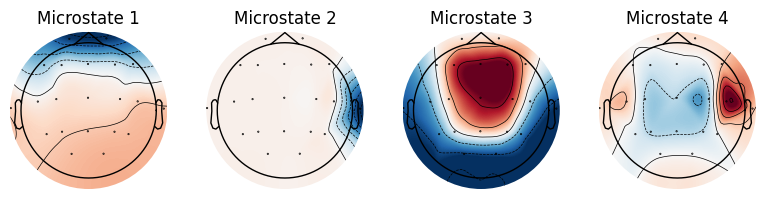

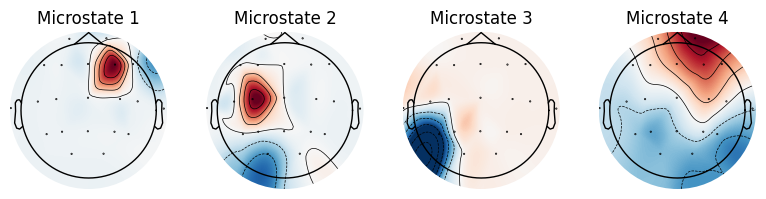

In [21]:
plot_maps(topo_maps['1'], raw.info)

plot_maps(topo_maps['11_1'], raw.info)
plot_maps(topo_maps['11_2'], raw.info)

plot_maps(topo_maps['12'], raw.info)
plot_maps(topo_maps['13'], raw.info)
plot_maps(topo_maps['14'], raw.info)
plot_maps(topo_maps['15'], raw.info)
plot_maps(topo_maps['all'], raw.info)